### Analyses of output files from the pipeline optimus v6.0.0
#### Aim of this part of analysis is to check if the output file from the pipeline is correct by realizing some preprocessing and visualization

#### Load necessary libraries and useful functions

In [1]:
%load_ext autoreload
%autoreload 2

In [84]:
from typing import Union
import fsspec
import anndata
import pandas as pd
import scanpy as sc
import seaborn as sns
import numpy as np
from cellbender.remove_background.downstream import anndata_from_h5
from upsetplot import from_contents
from upsetplot import UpSet
from scipy.stats import median_abs_deviation
import dalmatian as dm
import collections

In [4]:
def read_file_from_url(url: str) -> Union[anndata.AnnData, pd.DataFrame]:
    """Read a file from a URL and return the appropriate data structure.

    Parameters
    ----------
    url : str
        The URL of the file to read.

    Returns
    -------
    output : Union[anndata.AnnData, pd.DataFrame]
        The data read from the file, which can be either an AnnData object (if ".h5ad" in url)
        or a Pandas DataFrame (if ".csv" in url).
    """

    with fsspec.open(url) as f:
        if ".h5ad" in url:
            output = anndata.read_h5ad(f)
        elif "Summary.csv" in url:
            output = pd.read_csv(f, header=None) #Read the CSV file with the first row as data
        elif ".csv" in url:
            output = pd.read_csv(f)
        else:
            raise ValueError("Unsupported file format. Supported formats are .h5ad and .csv.")
    
    return output

In [6]:
def human_mt_genes_ident(in_adata: anndata.AnnData) -> None:
    """Identify human mitochondrial genes, add the boolean column "mt" to adata.var 
    This function also check if the adata contains mouse mt genes
    NB mitochondrial genes MT- for human data and mt- for mouse data
    
    Parameters
    ----------
    in_adata : AnnData
        The AnnData object to check.
    
    Returns
    -------
    output : None
    """
    
    count_true = (in_adata.var_names.str.startswith("mt-")).sum()
    
    if count_true > 0:
        print("Mouse mt number", count_true)
    else:
        print("No mouse mt genes")
        print("Adding human mt genes to adat.var")
        in_adata.var["mt"] = in_adata.var_names.str.startswith("MT-")

#### Data Loading

In this analysis, we load the data from the output file of job (submission ID 94e3d5584-ac31-456a-b046-4c8554108b7d)

In [7]:
TERRA_WS = "whitelabgx/scRNAseq"
wm = dm.WorkspaceManager(TERRA_WS)
output_df = wm.get_sample_sets()
display(output_df)
display(output_df.columns)

,aligner_metrics,bam,cell_calls,cell_metrics,cellbender_cell_barcodes_csv,cellbender_h5_array,cellbender_html_report_array,cellbender_metrics_csv_array,cellbender_summary_pdf,gene_metrics,genomic_reference_version,h5ad_output_file,matrix,matrix_col_index,matrix_row_index,samples
sample_set_id,,,,,,,,,,,,,,,,
optimus_workflow_2023-10-27,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,[gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/...,[gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/...,[gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,"[pbmc_10k_v3_S1_L001, pbmc_10k_v3_S1_L002]"


Index(['aligner_metrics', 'bam', 'cell_calls', 'cell_metrics',
       'cellbender_cell_barcodes_csv', 'cellbender_h5_array',
       'cellbender_html_report_array', 'cellbender_metrics_csv_array',
       'cellbender_summary_pdf', 'gene_metrics', 'genomic_reference_version',
       'h5ad_output_file', 'matrix', 'matrix_col_index', 'matrix_row_index',
       'samples'],
      dtype='object')

h5ad file of optimus (without cellbender correction)

###### You can load the h5ad directly form the bucket, or you can download it from the bucket and load it locally.

In [ ]:
### Load h5ad file
"""
h5ad_url = output_df.loc[output_df.index[0], 'h5ad_output_file']
#h5ad_url = output_df.loc['optimus_workflow_2023-10-27', 'h5ad_output_file']
adata = read_file_from_url(h5ad_url)
"""

In [8]:
### Load the data locally, more quickly
input_h5ad = "../scAtlas/tmp/10k_pbmc_v3.h5ad"
adata = sc.read_h5ad(input_h5ad)

/opt/homebrew/Caskroom/miniconda/base/envs/bulk/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [9]:
adata

AnnData object with n_obs × n_vars = 1136912 × 58347
    obs: 'cell_names', 'CellID', 'emptydrops_Limited', 'emptydrops_IsCell', 'n_reads', 'noise_reads', 'perfect_molecule_barcodes', 'reads_mapped_exonic', 'reads_mapped_exonic_as', 'reads_mapped_intronic', 'reads_mapped_intronic_as', 'reads_mapped_uniquely', 'reads_mapped_multiple', 'duplicate_reads', 'spliced_reads', 'antisense_reads', 'n_molecules', 'n_fragments', 'fragments_with_single_read_evidence', 'molecules_with_single_read_evidence', 'perfect_cell_barcodes', 'reads_mapped_intergenic', 'reads_unmapped', 'reads_mapped_too_many_loci', 'n_genes', 'genes_detected_multiple_observations', 'emptydrops_Total', 'molecule_barcode_fraction_bases_above_30_mean', 'molecule_barcode_fraction_bases_above_30_variance', 'genomic_reads_fraction_bases_quality_above_30_mean', 'genomic_reads_fraction_bases_quality_above_30_variance', 'genomic_read_quality_mean', 'genomic_read_quality_variance', 'reads_per_molecule', 'reads_per_fragment', 'fragments

###### check barcode and gene names

In [10]:
adata.var_names

Index(['DDX11L1', 'WASH7P', 'MIR6859-1', 'MIR1302-2HG', 'MIR1302-2', 'FAM138A',
       'AL627309.6', 'OR4G11P', 'OR4F5', 'AL627309.1',
       ...
       'pRNA', 'RNA5-8S5', 'pRNA', 'RNA5-8SN2', 'AC007325.3', 'AC007325.1',
       'AC007325.4', 'AC007325.2', 'U6', 'U1'],
      dtype='object', length=58347)

In [11]:
adata.obs_names

Index(['AAACCCAAGAAACACT', 'AAACCCAAGAAACCAT', 'AAACCCAAGAAACTAC',
       'AAACCCAAGAAACTCA', 'AAACCCAAGAAACTGT', 'AAACCCAAGAAAGCGA',
       'AAACCCAAGAAAGTCT', 'AAACCCAAGAAATCCA', 'AAACCCAAGAACGCGT',
       'AAACCCAAGAAGCCAC',
       ...
       'TTTGTTGTCTTCTAAC', 'TTTGTTGTCTTCTCTT', 'TTTGTTGTCTTCTTCC',
       'TTTGTTGTCTTGATTC', 'TTTGTTGTCTTGCGCT', 'TTTGTTGTCTTGGTCC',
       'TTTGTTGTCTTGTACC', 'TTTGTTGTCTTTACAC', 'TTTGTTGTCTTTGCGC',
       'TTTGTTGTCTTTGCTA'],
      dtype='object', length=1136912)

In [11]:
### check if there are no annotated genes (without gene names)
no_name_gene = adata.var[adata.var['Gene'] == ""]
print(f"{no_name_gene.shape[0]} genes without gene names")

0 genes without gene names


In [12]:
### Find duplicate variable (gene) names
var_names = adata.var_names
duplicates = [item for item, count in collections.Counter(var_names).items() if count > 1]

print("Duplicate variable names:", duplicates)
print("Number of duplicate variable:", len(duplicates))

Duplicate variable names: ['U6', 'TP73-AS1', 'Y_RNA', 'SNORA77', 'SCARNA16', 'SNORA70', 'SCARNA11', 'SCARNA17', 'SCARNA18', 'snoU13', 'SNORA44', 'SNORA16A', 'SCARNA24', 'Metazoa_SRP', 'uc_338', 'SNORA62', 'SNORA63', 'SNORD46', 'SNORD38B', 'SNORA26', 'SNORA58', 'DLEU2_6', 'DLEU2_5', 'DLEU2_4', 'DLEU2_3', 'DLEU2_2', 'DLEU2_1', 'SNORA31', 'SNORA2', 'SNORD81', 'SNORA51', 'SNORA25', 'SNORA42', 'U3', 'SNORA40', '7SK', 'U1', 'U2', '5S_rRNA', 'U6atac', 'U4', 'SNORD59', 'SCARNA4', 'SNORD64', 'ACA64', 'RGS5', 'SCARNA20', 'U7', 'SNORA67', 'SNORA72', 'SNORD60', 'SNORD116', 'U8', 'LINC01115', 'SNORD18', 'SCARNA21', 'SNORA36', 'SNORD75', 'TMEM247', 'STPG4', 'SNORA75', 'SNORA12', 'SNORD78', 'ACA59', 'SNORA74', 'snoU109', 'SNORA19', 'ACTR3BP2', 'DAOA-AS1_2', 'SCARNA15', 'SNORA48', 'SNORD56', 'PDE11A', 'SNORA43', 'SNORA17', 'PCGEM1', 'SNORA4', 'SNORD70', 'SNORD11', 'SNORA1', 'Vault', 'SNORD51', 'SCARNA6', 'SNORD39', 'LINC01238', 'GHRLOS', 'SNORD5', 'SNORA64', 'SNORD77', 'PRSS50', 'CYB561D2', 'SNORD19B'

###### Not all variable names are unique: This indicates that some variables (=genes) appear more than once which can lead to errors or unintended behavior for downstream analysis tasks. We execute the proposed function var_names_make_unique() which makes the variable name unique by appending a number string to each duplicate index element: ‘1’, ‘2’, etc.

In [13]:
### Variable names are not unique. To make them unique
adata.var_names_make_unique()

/opt/homebrew/Caskroom/miniconda/base/envs/bulk/lib/python3.9/site-packages/anndata/utils.py:260: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


Duplicate reads is zero for each cell: Optimus dev team will investigate that issue and create a GitHub issue for it.

In [14]:
display(adata.obs['duplicate_reads'].sum())

0

The following metrics are zero for each cell: check in bam file

In [38]:
#display(adata.obs['reads_mapped_exonic_as'].describe())
display(adata.obs['reads_mapped_intronic'].sum())
display(adata.obs['reads_mapped_intronic_as'].sum())
display(adata.obs['reads_mapped_exonic_as'].sum())
display(adata.obs['noise_reads'].sum())
display(adata.obs['antisense_reads'].sum())
display(adata.obs['reads_mapped_intergenic'].sum())

display(adata.obs['reads_mapped_exonic'])

0

0

0

0

0

0

AAACCCAAGAAACACT     1
AAACCCAAGAAACCAT     1
AAACCCAAGAAACTAC     3
AAACCCAAGAAACTCA    76
AAACCCAAGAAACTGT     2
                    ..
TTTGTTGTCTTGGTCC     1
TTTGTTGTCTTGTACC     1
TTTGTTGTCTTTACAC     1
TTTGTTGTCTTTGCGC    27
TTTGTTGTCTTTGCTA     3
Name: reads_mapped_exonic, Length: 1136912, dtype: int64

In [ ]:
# ! brew install samtools

###### Check the sF tag to understand why the metrics in above is zero

In [37]:
# ! samtools view -h /Users/xiliu/Documents/analysis/terraPipelines/scAtlas/tmp/Optimus_MergeBam_10k_pbmc_v3.bam | grep "sF:" | cut -f 19 | sort | uniq 

sF:B:i,-1,-1
sF:B:i,0,0
sF:B:i,1,1
sF:B:i,1,10
sF:B:i,1,11
sF:B:i,1,12
sF:B:i,1,2
sF:B:i,1,22
sF:B:i,1,3
sF:B:i,1,4
sF:B:i,1,5
sF:B:i,1,6
sF:B:i,1,7
sF:B:i,1,8
sF:B:i,1,9


#### STARsolo summary

In [12]:
### Load STARsolo summary file
star_summary_url = "gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/submissions/96ae8c73-2b91-4a30-b188-2a25a341a459/Optimus/be8bc5cc-dfaf-4e7f-905c-e92735750bb5/call-STARsoloFastq/shard-1/cacheCopy/Summary.csv"
star_summary = read_file_from_url(star_summary_url)
display(star_summary)

,0,1
0,Number of Reads,319930655
1,Reads With Valid Barcodes,0.973214
2,Sequencing Saturation,0.667937
3,Q30 Bases in CB+UMI,0.931203
4,Q30 Bases in RNA read,0.901736
5,Reads Mapped to Genome: Unique+Multiple,0.961733
6,Reads Mapped to Genome: Unique,0.889793
7,Reads Mapped to Gene: Unique+Multiple Gene,NoMulti
8,Reads Mapped to Gene: Unique Gene,0.47964
9,Estimated Number of Cells,5356


#### Check if we have zero counts droplets

In [13]:
print(f"{adata.obs.loc[adata.obs.n_reads == 0, :].shape[0]} zero count cell")

0 zero count cell


In [ ]:
"""
# the same as above
no_0count_cell = adata.obs.loc[adata.obs.n_reads != 0, :]
no_0count_cell
"""

#### Ambient RNA detection comparison

EmptyDrop results and filtering

In [16]:
# Fetch the total number of barcodes
total_nb_barcodes = adata.n_obs

In [15]:
### fetch the rows where the column emptydrops_IsCell is True
emptydrops_IsCell_true = adata.obs.loc[adata.obs.emptydrops_IsCell, :]
#emptydrops_IsCell_true= adata.obs[adata.obs['emptydrops_IsCell'] == True]
emptydrops_IsCell_true_FDR001 = emptydrops_IsCell_true.loc[emptydrops_IsCell_true.emptydrops_FDR < 0.001, :]

print(f"{emptydrops_IsCell_true.shape[0]} barcodes are identified as cells by emptydrops with FDR < 0.01")
print(f"{emptydrops_IsCell_true_FDR001.shape[0]} barcodes are identified as cells by emptydrops with FDR < 0.001")

11031 barcodes are identified as cells by emptydrops with FDR < 0.01
10710 barcodes are identified as cells by emptydrops with FDR < 0.001


In [17]:
# Calculate the barcode surviving pct
cell_contain_cb_pct = emptydrops_IsCell_true.shape[0] * 100 / total_nb_barcodes
print(f"{cell_contain_cb_pct:.2f} % of barcodes survived after emptydrops filtering with FDR < 0.01")


0.97 % of barcodes survived after emptydrops filtering with FDR < 0.01


Hard thresholding and emptyDrops comparison

In [18]:
barcodes_sup500, _ = sc.pp.filter_cells(adata, min_counts=500, inplace=False)
adata_BCsup500 = adata[barcodes_sup500, :]

adata_BCsup500_emptydrops_IsCell_true = adata_BCsup500 .obs.loc[adata_BCsup500.obs.emptydrops_IsCell, :]

adata_BCsup500_emptydrops_IsCell_true_FDR001 = adata_BCsup500_emptydrops_IsCell_true.loc[
    adata_BCsup500_emptydrops_IsCell_true.emptydrops_FDR < 0.001, :
    ]

print(f"{total_nb_barcodes} barcodes in this dataset")
print(f"{adata_BCsup500.shape[0]} barcodes have at least 500 reads")
print(f"{adata_BCsup500_emptydrops_IsCell_true.shape[0]} barcodes have at least 500 reads and identified as cells by emptydrops with FDR < 0.01")
print(f"{adata_BCsup500_emptydrops_IsCell_true_FDR001.shape[0]} barcodes have at least 500 reads and identified as cells by emptydrops with FDR < 0.001")

1136912 barcodes in this dataset
12283 barcodes have at least 500 reads
10757 barcodes have at least 500 reads and identified as cells by emptydrops with FDR < 0.01
10590 barcodes have at least 500 reads and identified as cells by emptydrops with FDR < 0.001


Cellbender results

In [19]:
### Fetch the links of CellBender h5 files from Terra
h5_url = output_df.loc[output_df.index[0], 'cellbender_h5_array']h5_url

['gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/submissions/4e3d5584-ac31-456a-b046-4c8554108b7d/Optimus/61a7a407-6620-4a45-b7e9-25f5c2a9bf21/call-cellbender_remove_background/cacheCopy/glob-a06ff40aeb9faf0d800aaf11b27f640c/10k_pbmc_v3_out.h5',
 'gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/submissions/4e3d5584-ac31-456a-b046-4c8554108b7d/Optimus/61a7a407-6620-4a45-b7e9-25f5c2a9bf21/call-cellbender_remove_background/cacheCopy/glob-a06ff40aeb9faf0d800aaf11b27f640c/10k_pbmc_v3_out_filtered.h5',
 'gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/submissions/4e3d5584-ac31-456a-b046-4c8554108b7d/Optimus/61a7a407-6620-4a45-b7e9-25f5c2a9bf21/call-cellbender_remove_background/cacheCopy/glob-a06ff40aeb9faf0d800aaf11b27f640c/10k_pbmc_v3_out_posterior.h5']

In [42]:
# Load data
adata_cellbender_out_filtered = anndata_from_h5('/Users/xiliu/Documents/analysis/terraPipelines/scAtlas/tmp/10k_pbmc_v3_out_filtered.h5')
adata_cellbender_out = anndata_from_h5('/Users/xiliu/Documents/analysis/terraPipelines/scAtlas/tmp/10k_pbmc_v3_out.h5')
#adata_cellbender_out_posterior = anndata_from_h5('/Users/xiliu/Documents/analysis/terraPipelines/scAtlas/tmp/10k_pbmc_v3_out_posterior.h5')

display(adata_cellbender_out_filtered)
display(adata_cellbender_out)
#display(adata_cellbender_out_posterior)


Assuming we are loading a "filtered" file that contains only cells.


/opt/homebrew/Caskroom/miniconda/base/envs/bulk/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/bulk/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 3605 × 58347
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed'
    uns: 'barcode_indices_for_latents', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swapping_fraction_dist_params', 'barcodes_analyzed', 'barcodes_analyzed_inds', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'target_false_positive_rate'
    obsm: 'gene_expression_encoding'

AnnData object with n_obs × n_vars = 4118 × 58347
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swapping_fraction_dist_params', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'target_false_positive_rate'
    obsm: 'gene_expression_encoding'

In [43]:
adata_cellbender_out.var

,ambient_expression,feature_type,genome,gene_id,cellbender_analyzed
gene_name,,,,,
DDX11L1,0.000000,NA,NA,ENSG00000223972.5,False
WASH7P,0.000000,NA,NA,ENSG00000227232.5,False
MIR6859-1,0.000000,NA,NA,ENSG00000278267.1,False
MIR1302-2HG,0.000000,NA,NA,ENSG00000243485.5,False
MIR1302-2,0.000000,NA,NA,ENSG00000284332.1,False
...,...,...,...,...,...
AC007325.1,0.000000,NA,NA,ENSG00000276017.1,False
AC007325.4,0.000002,NA,NA,ENSG00000278817.1,True
AC007325.2,0.000000,NA,NA,ENSG00000277196.4,False


In [59]:
adata_cellbender_out.obs

,background_fraction,cell_probability,cell_size,droplet_efficiency
barcode,,,,
TGCTTGCTCTAAGCCA,0.066727,0.999955,36923.042969,2.498647
AATCACGTCCCGATCT,0.130501,0.999955,26296.291016,2.491069
TTCCTTCAGTCTCCTC,0.109683,0.999955,25463.599609,2.469484
CTTGAGATCCATGCAA,0.115368,0.999955,25576.208984,2.452932
TCATTACCAGCTCATA,0.134150,0.999955,22964.462891,2.399945
...,...,...,...,...
CTGATCCCAGTCAGCC,0.000000,0.012916,11271.076172,1.048951
GGTGTCGAGCGGGTTA,0.701669,0.992517,17560.492188,0.568851
CTCAAGACAGTGCCTG,0.000000,0.028803,10847.955078,1.148832


comparison between 3 methods and their 5 results

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

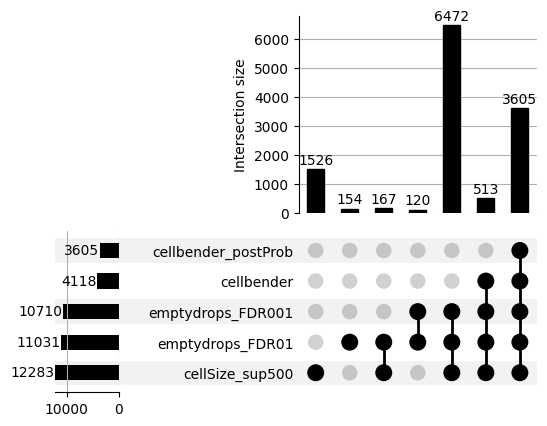

In [91]:
emptydrops_FDR01 = emptydrops_IsCell_true.index.to_list()
emptydrops_FDR001 = emptydrops_IsCell_true_FDR001.index.to_list()
cellSize_sup500 = adata_BCsup500.obs.index.to_list()
cellbender = adata_cellbender_out.obs.index.to_list()
cellbender_postProb = adata_cellbender_out_filtered.obs.index.to_list()
(emptydrops_FDR01, emptydrops_FDR001, cellSize_sup500, cellbender, cellbender_postProb)


IsCell = from_contents({'emptydrops_FDR01': emptydrops_FDR01,
                             'emptydrops_FDR001': emptydrops_FDR001,
                             'cellSize_sup500': cellSize_sup500,
                             'cellbender': cellbender,
                             'cellbender_postProb': cellbender_postProb})

UpSet(IsCell, subset_size='count', show_counts=True).plot()

In [ ]:
emptydrops_FDR01 = emptydrops_IsCell_true.index.to_list()
cellSize_sup500 = adata_BCsup500.obs.index.to_list()
cellbender = adata_cellbender_out.obs.index.to_list()
(emptydrops_FDR01, cellSize_sup500, cellbender,)


IsCell_lax = from_contents({'emptydrops_FDR01': emptydrops_FDR01,
                             'cellSize_sup500': cellSize_sup500,
                             'cellbender': cellbender,})

UpSet(IsCell_lax, subset_size='count', show_counts=True).plot()

#### Mitochondrial RNA detection comparison

In [44]:
# Create variable of mithocondrial genes in adata.var
human_mt_genes_ident(adata)

No mouse mt genes
Adding human mt genes to adat.var


In [45]:
# Fetch rows where "mt" is True
mt_genes_by_prefix = adata.var[adata.var['mt']]
print(f"{mt_genes_by_prefix.shape[0]} mt genes in this dataset")

37 mt genes in this dataset


###### Pourcentage of Mitochondrial RNA using scanpy

In [46]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, percent_top=None, log1p=True
)
adata

AnnData object with n_obs × n_vars = 1136912 × 58347
    obs: 'cell_names', 'CellID', 'emptydrops_Limited', 'emptydrops_IsCell', 'n_reads', 'noise_reads', 'perfect_molecule_barcodes', 'reads_mapped_exonic', 'reads_mapped_exonic_as', 'reads_mapped_intronic', 'reads_mapped_intronic_as', 'reads_mapped_uniquely', 'reads_mapped_multiple', 'duplicate_reads', 'spliced_reads', 'antisense_reads', 'n_molecules', 'n_fragments', 'fragments_with_single_read_evidence', 'molecules_with_single_read_evidence', 'perfect_cell_barcodes', 'reads_mapped_intergenic', 'reads_unmapped', 'reads_mapped_too_many_loci', 'n_genes', 'genes_detected_multiple_observations', 'emptydrops_Total', 'molecule_barcode_fraction_bases_above_30_mean', 'molecule_barcode_fraction_bases_above_30_variance', 'genomic_reads_fraction_bases_quality_above_30_mean', 'genomic_reads_fraction_bases_quality_above_30_variance', 'genomic_read_quality_mean', 'genomic_read_quality_variance', 'reads_per_molecule', 'reads_per_fragment', 'fragments

###### Comparison between scanpy and optimus: Number of no mitochondrial molecules cells are the same => Mt genes identification should be the same

In [47]:
zero_pct_mt_cellNB_optimus = adata.obs[adata.obs["pct_mitochondrial_molecules"] == 0]
print(f"{zero_pct_mt_cellNB_optimus.shape[0]} cell with 0% mitochondrial molecules using optimus pct_mitochondrial_molecules attribute")

zero_pct_mt_cellNB_sc = adata.obs[adata.obs["pct_counts_mt"] == 0]
print(f"{zero_pct_mt_cellNB_sc.shape[0]} cell with 0% mitochondrial molecules using scanpy pct_counts_mt attribute")

778221 cell with 0% mitochondrial molecules using optimus pct_mitochondrial_molecules attribute
778221 cell with 0% mitochondrial molecules using scanpy pct_counts_mt attribute


Comparison between scanpy and optimus: Number of mitochondrial molecules in cells

In [48]:
# Create a boolean mask to check if A and B are different
mask = adata.obs['n_mitochondrial_molecules'] != adata.obs['total_counts_mt']

# Use the boolean mask to filter the rows where A and B are different
diff_mt_nb = adata.obs[mask]
print(f"{diff_mt_nb.shape[0]} cells with different number of mitochondrial molecules using optimus and scanpy attribute")

238400 cells with different number of mitochondrial molecules using optimus and scanpy attribute


In [49]:
# scanpy - optimus metrics
diff_mt_nb[[ 'total_counts', 'total_counts_mt',"pct_counts_mt",
             'n_reads','n_mitochondrial_molecules','pct_mitochondrial_molecules']]

,total_counts,total_counts_mt,pct_counts_mt,n_reads,n_mitochondrial_molecules,pct_mitochondrial_molecules
AAACCCAAGAAGTCTA,23.0,3.0,13.043478,73,6,8.219178
AAACCCAAGAATCTAG,3.0,1.0,33.333336,17,4,23.529411
AAACCCAAGACAACAT,97.0,5.0,5.154639,270,8,2.962963
AAACCCAAGACAACTA,2.0,1.0,50.000000,19,3,15.789473
AAACCCAAGACCACGA,89.0,5.0,5.617978,264,6,2.272727
...,...,...,...,...,...,...
TTTGTTGTCTGTCAGA,1.0,1.0,100.000000,2,2,100.000000
TTTGTTGTCTGTGCGG,2.0,1.0,50.000000,3,2,66.666672
TTTGTTGTCTTACTGT,6827.0,541.0,7.924417,54064,1671,3.090781
TTTGTTGTCTTCTAAC,1759.0,511.0,29.050598,29895,1604,5.365446


###### n_reads is always greater than total_counts

In [50]:
CB_index = adata.obs.index
target_CB = "TTTGTTGTCTTGATTC"

# Use numpy.where to find the positions where the condition is True
positions = np.where(CB_index == target_CB)[0][0]
display(positions)


1136905

In [51]:
# check if cell size is 1
total_sum = np.sum(adata.X[positions, : ])
display(total_sum)

# get the mt gene name
nonzero_positions = np.nonzero(adata.X[positions, :].toarray() != 0)[1][0]
display(nonzero_positions)
adata.var.index[nonzero_positions]

1.0

58273

'MT-CO3'

In [52]:
difference = adata.obs['n_reads'] - adata.obs['total_counts']
negative_values = difference[difference < 0]
negative_values

Series([], dtype: float64)

###### total_counts of Scanpy is the same as emptydrops_Total

In [53]:
mask = adata.obs['total_counts'] != adata.obs['emptydrops_Total']
print(f"{adata.obs[mask].shape[0]} differences between total_counts and emptydrops_Total")

0 differences between total_counts and emptydrops_Total


###### compare total_counts of Scanpy and cell size by summing up the counts of each column by row in adata.X

In [54]:
cell_total_count_in_adataX = np.ravel(adata.X.sum(axis=1))

# Convert the pandas Series to a NumPy array
total_count_np = adata.obs['total_counts'].values

mask = total_count_np != cell_total_count_in_adataX
print(f"{adata.obs[mask].shape[0]} differences between total_counts and cell size")

0 differences between total_counts and cell size


#### Mitochondrial RNA detection comparison

without emptydrops filtering

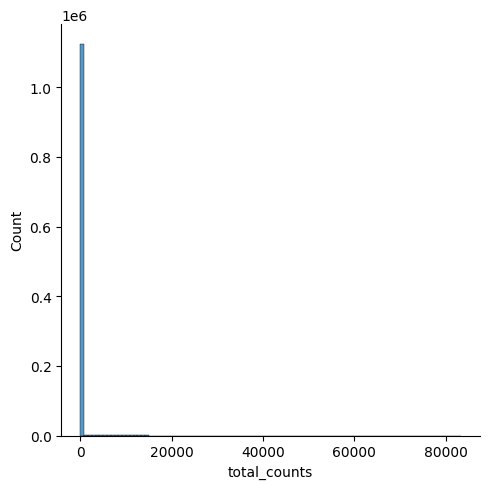

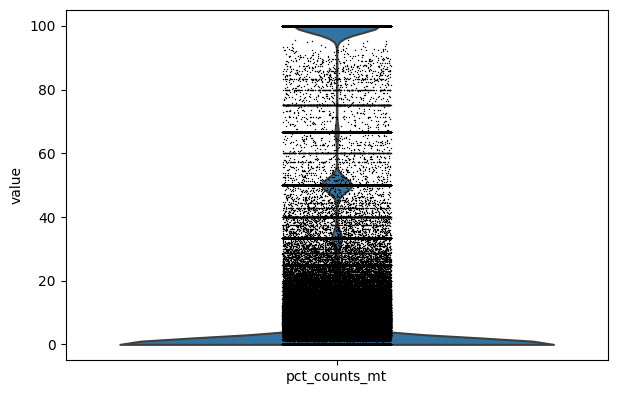

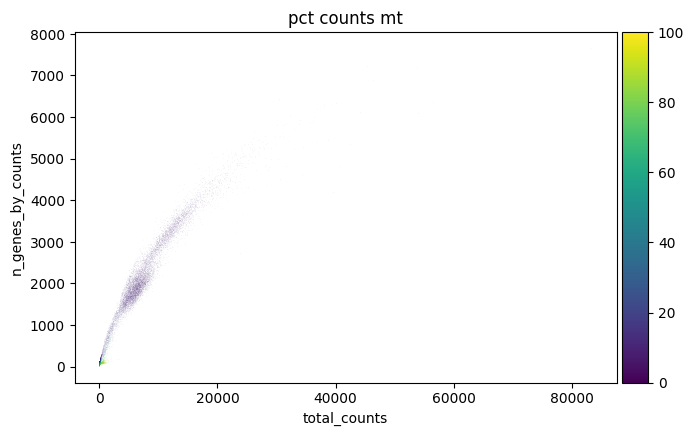

In [55]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [56]:
# TODO: need to remove the %mt: see p2

In [57]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [58]:
# We now apply this function to the log1p_total_counts, log1p_n_genes_by_counts 
# and pct_counts_in_top_20_genes QC covariates each with a threshold of 5 MADs.
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

KeyError: 'pct_counts_in_top_20_genes'

In [ ]:
#pct_counts_Mt is filtered with 3 MADs. Additionally, cells with 
#a percentage of mitochondrial counts exceeding 8 % are filtered out
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

True     9993
False    2290
Name: mt_outlier, dtype: int64

In [ ]:
#We now filter our AnnData object based on these two additional columns.
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 12283
Number of cells after filtering of low quality cells: 2237


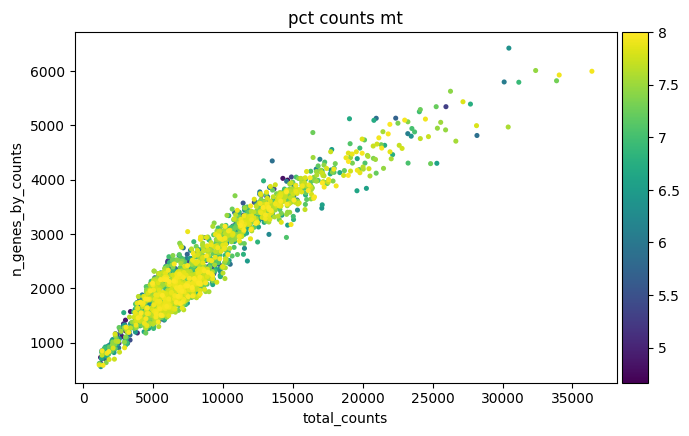

In [ ]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

#### 4. Correction of ambient RNA

In [ ]:
adata.layers["log_transformed"] = np.log1p(adata.X)
adata.to_df(layer="log_transformed")


In [ ]:
#faire QC, %mh,..., après umap
#cellbender prendre .h5 comme input
# read -> cell ranger -> raw count matrix + matrix retiré les barces peu reads/les empty droplet

#### Draft **********

In [ ]:
#import warnings
#warnings.filterwarnings("ignore")  # suppress warnings

raw data understanding

In [ ]:
### duplicate reads is always 0
display(adata.obs[adata.obs['duplicate_reads']== 0])
#display(adata.obs['duplicate_reads'].value_counts())

In [ ]:
### Fetch the data where the variable names are empty: they are probably absent in the reference annotation

# Access the 'var' attribute to work with variable information
var_df = adata.var
# Filter the data where the variable names are empty
empty_var_names = var_df[var_df.index == '']
#data_with_empty_var_names = adata[:, empty_var_names]
display(empty_var_names.head())

### check double variable names in the data with empty variable names
# Remove the variables with empty names from the 'adata' object
no_empty_varName_adata = adata[:, ~adata.var.index.isin(empty_var_names.index)]
no_empty_varName_adata

In [ ]:
display(adata.uns)

OverloadedDict, wrapping:
	{'expression_data_type': 'exonic', 'input_id': '10k_pbmc_v3', 'optimus_output_schema_version': '1.0.1', 'pipeline_version': 'Optimus_v6.0.0'}
With overloaded keys:
	['neighbors'].

In [ ]:
import numpy as np

# sparse matrix is named 'sparse_matrix'
sparse_matrix = adata.X

# Convert the sparse matrix to a dense NumPy array
dense_matrix = sparse_matrix.toarray()

# use regular NumPy indexing to see the head
head = dense_matrix[:5, :]  # Assuming you want to see the first 5 rows
print(head)

In [ ]:
result = adata.obs[["reads_mapped_exonic", "reads_mapped_intergenic"]].sum(axis=1)

In [ ]:
### find the calculation of pct_mitochondrial_molecules
pct_mt=adata.obs["n_mitochondrial_molecules"]/adata.obs["n_reads"]*100

# Compare the two Series
if pct_mt.equals(adata.obs["pct_mitochondrial_molecules"]):
    print("The two Series are the same.")
else:
    print("The two Series are different.")

# output the different between 2 Series
for idx, (val1, val2) in enumerate(zip(pct_mt, adata.obs["pct_mitochondrial_molecules"])):
    if val1 != val2:
        print(f"Difference at index {idx}:")
        print(f"Difference at index {adata.obs['CellID'].iloc[idx]}:")
        
        print(f"pct_mt: {val1}")
        print(f"pct_mt_in_h5ad: {val2}")
# the 2 results are almost the same

In [ ]:
# remove a variable from adata.var
adata.var.drop(variable_name, axis=1, inplace=True)

In [ ]:
# Read the compressed CSV file into a DataFrame using a url
import pandas as pd

with fsspec.open(gene_metrics, 'rb') as f:
    df = pd.read_csv(f, compression='gzip')

In [ ]:
# read a csv.gz file on local
mport gzip

file_path = '../scAtlas/tmp/cell-metrics.csv'

# Open the compressed file and read it using pandas
with gzip.open(file_path, 'rt', encoding='utf-8') as file:
    cell_metrics = pd.read_csv(file)

In [ ]:
# compare the difference from 2 Series
for idx, (val1, val2) in enumerate(zip(pct_mt_optimus, pct_mt_theis)):
    if val1 != val2:
        print(f"Difference at index {idx}:")
        print(f"Difference at index {adata.obs['CellID'].iloc[idx]}:")
        
        print(f"pct_mt_optimus: {val1}")
        print(f"pct_mt_theis: {val2}")

In [ ]:
# Check difference between n_reads and perfect_molecule_barcodes
mask = adata.obs['n_mitochondrial_molecules'] != adata.obs['perfect_molecule_barcodes']

diff_nb = adata.obs[mask]
print(f"{diff_nb.shape[0]} cells with different number of n_reads and perfect_molecule_barcodes")

1047915 cells with different number of n_reads and perfect_molecule_barcodes
